# The Jam Machine 

## decription of the model here
### - Sequence length 1024
### - whole dataset
### - tristan's encoder
### - improved features
    - pushing on Hugging face
    - writing the tokenized dataset on disk
    - loading the tokenized dataset --> saves times for big datasets


# Imports

In [1]:
## THIS NEEDS TO BE CLEANED - NOT EVERYTHING IS NECESSARY
# basic packages requirements
!pip install wandb
import os
from pathlib import Path
import glob
import random
import shutil
import tqdm
import matplotlib.pyplot as plt
import typing
import json
# tensorflow
# import tensorflow as tf
# from tensorflow.keras import preprocessing
# from tensorflow.keras import models, layers
# tf.config.list_physical_devices("GPU")
# transformers
!pip install transformers tokenizers
from transformers import PreTrainedTokenizerFast
from transformers import DataCollatorForLanguageModeling
from transformers import GPT2Config, GPT2LMHeadModel
from transformers import TrainingArguments, Trainer
# tokenizer
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
# torch
import torch

# install requirements
# !pipenv lock -r > requirements.txt
# !pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Setup requirements
Here you should set the path for saving your trained model etc

In [2]:
!git clone https://github.com/m41w4r3exe/the-jam-machine.git

# move into the git folder to have all scripts in the local folder
os.chdir("./the-jam-machine")

# check that we re in the right happy place
print(f"Current working directory: {os.getcwd()}")
print(f"Files and Folders in directory:")
os.listdir()

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# define path
drive_path = Path("/content/drive/MyDrive/the_jam_machine/")
# midi_path = Path(f"{drive_path}/midi_data")
# encoded_midi_path = Path(f"{drive_path}/midi_encoded")

# DATA
encoded_midi_path = Path(f"{drive_path}/midi_encoded_by_tristan")

# TOKENIZER
tokenizer_path = Path(f"{drive_path}/tokenizer")
tokenizer_file = "tokenizer.json"
load_tokenizer_pretrained = True
load_tokenized_datasets = True

# MODEL
model_path = Path(f"{drive_path}/model_jean_1024_8layers")
if not os.path.exists(model_path):
  print(f"creating {model_path}")
  os.mkdir(model_path)

# HuggingFace repo
hf_repo = "misnaej/the-jam-machine-1024"
hf_token = "#######"

# device = "cpu"
device = "cuda" 
train_from_scratch = True


fatal: destination path 'the-jam-machine' already exists and is not an empty directory.
Current working directory: /content/the-jam-machine
Files and Folders in directory:
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Encoding Midi into Text (Done already)
from `mymusic.mid` files from `midi_path` to `music.txt` files in `encoded_midi_path`

In [3]:
#@title File encoding
#!python encoder_mlike.py --midi_path {midi_path} --encoded_midi_path {encoded_midi_path}

# Dataset
- load the encoded data
- training set - ?? % (done already by Tristan's encoding)
- validation set - ?? % (done already by Tristan's encoding)

- Tokenizing


## Loading the data

Define data path and define individual path for every files

In [4]:
# write full filepath to list
def full_filepath_to_list(dataset_folder, file_limit=1000):
  dataset_files = os.listdir(dataset_folder)
  dataset_files = [f"{dataset_folder}/{file}" for count, file in enumerate(dataset_files) if count < file_limit]
  print(dataset_files)
  return dataset_files

dataset_path = encoded_midi_path;
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")

files_train = full_filepath_to_list(dataset_path_train) # training set
files_valid = full_filepath_to_list(dataset_path_valid) # validation set

['/content/drive/MyDrive/the_jam_machine/midi_encoded_by_tristan/train/token-sequences-2.txt', '/content/drive/MyDrive/the_jam_machine/midi_encoded_by_tristan/train/token-sequences-4.txt', '/content/drive/MyDrive/the_jam_machine/midi_encoded_by_tristan/train/token-sequences-6.txt', '/content/drive/MyDrive/the_jam_machine/midi_encoded_by_tristan/train/token-sequences-1.txt', '/content/drive/MyDrive/the_jam_machine/midi_encoded_by_tristan/train/token-sequences-9.txt', '/content/drive/MyDrive/the_jam_machine/midi_encoded_by_tristan/train/token-sequences-7.txt', '/content/drive/MyDrive/the_jam_machine/midi_encoded_by_tristan/train/token-sequences-8.txt', '/content/drive/MyDrive/the_jam_machine/midi_encoded_by_tristan/train/token-sequences-3.txt', '/content/drive/MyDrive/the_jam_machine/midi_encoded_by_tristan/train/token-sequences-0.txt', '/content/drive/MyDrive/the_jam_machine/midi_encoded_by_tristan/train/token-sequences-5.txt']
['/content/drive/MyDrive/the_jam_machine/midi_encoded_by_tr

## Put data into dictionnary

In [5]:
# TO CHANGE  - this will probably give us some memory issues 
# Dictionnary stage to skip here and load the date into the tokenizer directly from the text files
# show the first 2 items
def show_n_first_dataset_entries(dataset, n=2):
  for idx, key in enumerate(dataset.values()):
    if idx >= n:
      break
    else:
      print(key)

def dataset_in_dictionary(files):
  dataset_dict = {}
  dataset_size = 0
  for _ , file in enumerate(files):
    line_count = 0

    filename = file.split("/")[-1].split(".")[0]
    file_content = open(file, "r")

    while True:
      line_count += 1
      line =  file_content.readline().rstrip("\n") 
      dataset_size += 1
      if line_count % 10000 == 0:
        print(f"Writting - {filename} - count={line_count}")
        print(line)  

      if not line: # break when file is over
        print(f"Breaking - {filename} - count={line_count}")
        print(line)
        
        break

      dataset_dict[f"{filename}_{line_count}"] = line

    

  show_n_first_dataset_entries(dataset_dict, n=2)

  return dataset_dict, dataset_size

if not load_tokenized_datasets:
  print("=============")  
  print("Training data")
  print("=============")
  dataset_train_dict, dataset_train_size = dataset_in_dictionary(files_train)
  print(f"dataset_train_size = {dataset_train_size}")
  print("===============")
  print("Validation data")
  print("===============")
  dataset_valid_dict, dataset_valid_size = dataset_in_dictionary(files_valid)
  print(f"dataset_valid_size = {dataset_valid_size}")
  # print(f"dataset length: {len(dataset_train_dict.items()}")

# Tokenizer



## Train the TOKENIZER

In [6]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers.trainers import WordLevelTrainer
from transformers import PreTrainedTokenizerFast


# making an iterator to go through the dictionary 
# CHANG THIS TO LOAD DIRECTLY FROM THE FILES TO SAVE MEMORY
def get_training_corpus():
    for song in dataset_train_dict.values():
        yield song

def define_and_save_tokenizer(
  saved_tokenizer="tokenizer.json", 
  tokenizer_path="./"
):
  # using a Word Level Tokemizer
  tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
  # separating vocabulary on whitespaces (pretokenizer)
  tokenizer.pre_tokenizer = WhitespaceSplit()
  # set up the trainer 
  trainer = WordLevelTrainer(
      special_tokens=["[UNK]", "[PAD]", "[MASK]"]
  )
  # special tokens I took the ones tristan used but I am not sure I understand all of them 
  # [UNK] always need and UNK token
  # [PAD] if we need to do some pading
  # [MASK] if when we need to mask, in order to predict the future without seeing it
  # [CLS] what is it ? it is for BERT - the last token of the sequence
  # [SEP] what is it ? - SEP can be used with very short sequences

  # get corpus
  training_corpus = get_training_corpus()
  # train tokenizer
  tokenizer.train_from_iterator(training_corpus, trainer=trainer)
  # save tokenizer
  tokenizer.save(f"{tokenizer_path}/{saved_tokenizer}")

  return tokenizer

if not load_tokenizer_pretrained:
  tokenizer = define_and_save_tokenizer(tokenizer_path=tokenizer_path)


## Or load the trained tokenizer


In [7]:
if load_tokenizer_pretrained:
  from transformers import PreTrainedTokenizerFast
  # if device == "cuda":
  #   tokenizer = PreTrainedTokenizerFast(tokenizer_file=f"{tokenizer_path}/{tokenizer_file}")
  # else:
    # tokenizer = PreTrainedTokenizerFast(tokenizer_file=f"{tokenizer_path}/{tokenizer_file}")
  tokenizer = PreTrainedTokenizerFast(tokenizer_file=f"{tokenizer_path}/{tokenizer_file}")

 ## Make it ready for GPT2 : add the pad_token

In [8]:
def format_tokenizer_for_transformers_classes(saved_tokenizer="tokenizer.json"):
  # PreTrainedTokenizerFast makes the tokenizer usable by the transformer
  tokenizer = PreTrainedTokenizerFast(tokenizer_file = saved_tokenizer)
  tokenizer.add_special_tokens({'pad_token': '[PAD]'})

  return tokenizer

tokenizer = format_tokenizer_for_transformers_classes(
    saved_tokenizer=f"{tokenizer_path}/{tokenizer_file}"
)

## Visualize the Vocabulary

In [9]:
print(tokenizer.vocab_size)
tokenizer.get_vocab()

413


{'NOTE_ON=94': 185,
 'INST=27': 162,
 'NOTE_ON=53': 66,
 'NOTE_OFF=37': 96,
 'NOTE_ON=117': 381,
 'NOTE_OFF=15': 304,
 'INST=59': 354,
 'NOTE_OFF=74': 88,
 'NOTE_ON=3': 402,
 'NOTE_ON=105': 272,
 'NOTE_OFF=51': 49,
 'INST=35': 183,
 'NOTE_ON=120': 389,
 'NOTE_ON=75': 107,
 'INST=45': 270,
 'NOTE_ON=127': 373,
 'NOTE_ON=114': 379,
 'NOTE_ON=13': 412,
 'INST=119': 235,
 'NOTE_OFF=122': 368,
 'NOTE_OFF=99': 223,
 'INST=87': 209,
 'INST=7': 241,
 'INST=68': 263,
 'NOTE_OFF=57': 21,
 'NOTE_OFF=105': 271,
 'NOTE_ON=64': 20,
 'NOTE_ON=40': 15,
 'NOTE_OFF=60': 33,
 'TIME_DELTA=11': 158,
 'NOTE_OFF=120': 387,
 'NOTE_ON=78': 121,
 'NOTE_ON=35': 17,
 'NOTE_OFF=2': 388,
 'NOTE_OFF=11': 403,
 'INST=1': 197,
 'NOTE_OFF=106': 363,
 'NOTE_OFF=125': 376,
 'NOTE_ON=51': 50,
 'TIME_DELTA=10': 137,
 'NOTE_OFF=94': 184,
 'NOTE_ON=54': 26,
 'INST=80': 211,
 'TIME_DELTA=8': 90,
 'NOTE_OFF=21': 217,
 'NOTE_OFF=33': 84,
 'INST=6': 239,
 'INST=36': 240,
 'INST=124': 330,
 'NOTE_OFF=48': 57,
 'INST=52': 194,
 'I

## Tokenize the DATASET and prepare it for the model

In [10]:
def tokenize_function(data_to_tokenize):
  # this make the tokenized data ready for the model that requires a
    tokenized_data = tokenizer(
        data_to_tokenize,
        truncation=True,
        padding=True,
        max_length=1024,
    )
    return {
        "input_ids": tokenized_data["input_ids"]
    } 

def tokenize_dataset(dataset_dictionary, tokenizer, limit=None):
  if limit is None:
    limit = len(dataset_dictionary.items())

  tokenized_dictionary=[]
  for idx, file in enumerate(dataset_dictionary.values()):
    # print(file)
    if idx<limit:
      tokenized_dictionary.append(tokenize_function(file))
      # print(encoded_file)

  return tokenized_dictionary

def write_to_json(file, path):
  with open(f"{path}", 'w') as json_file:
    json.dump(file, json_file)

def load_json(path):
  with open(f"{path}", 'r') as json_file:
    file = json.load(json_file)
    return file

if not load_tokenized_datasets:
  dataset_train_tokenized = tokenize_dataset(dataset_train_dict,tokenizer)
  dataset_val_tokenized = tokenize_dataset(dataset_valid_dict,tokenizer)

  write_to_json(dataset_val_tokenized, f"{model_path}/dataset_val_tokenized.json")
  write_to_json(dataset_train_tokenized, f"{model_path}/dataset_train_tokenized.json")

In [11]:
if load_tokenized_datasets:
  dataset_train_tokenized = load_json(f"{model_path}/dataset_train_tokenized.json")
  dataset_val_tokenized = load_json(f"{model_path}/dataset_val_tokenized.json")

In [16]:
# checking that the data is in the correct shape to be input to the model
assert list(dataset_train_tokenized[0]) == ["input_ids"], list(dataset_train_tokenized[0])
print(type(dataset_train_tokenized[0]))
# Check a few samples
for i, ii in enumerate(dataset_train_tokenized):
  if i > 4: # print only the first 5
    break
  else: 
    print("----")
    # print(ii)
    print(dataset_train_tokenized[i])

<class 'dict'>
----
{'input_ids': [136, 52, 203, 127, 6, 5, 6, 5, 6, 5, 6, 81, 54, 3, 53, 64, 3, 63, 20, 3, 19, 64, 3, 63, 20, 3, 19, 56, 3, 55, 87, 11, 86, 5, 6, 5, 6, 5, 6, 5, 6, 5, 51, 52, 183, 127, 6, 5, 6, 5, 6, 8, 3, 7, 70, 4, 69, 8, 3, 7, 46, 11, 45, 46, 11, 45, 46, 4, 45, 8, 4, 7, 5, 6, 68, 133, 67, 5, 6, 103, 3, 102, 5, 6, 5, 6, 5, 6, 5, 51, 52, 203, 127, 6, 5, 6, 5, 6, 5, 6, 54, 28, 20, 22, 91, 53, 27, 19, 21, 5, 6, 5, 6, 5, 6, 5, 6, 5, 51, 52, 161, 124, 6, 5, 6, 5, 6, 8, 3, 87, 4, 86, 32, 3, 31, 22, 93, 20, 26, 3, 92, 101, 4, 100, 93, 3, 92, 132, 4, 131, 139, 4, 138, 132, 4, 131, 80, 4, 7, 21, 19, 25, 79, 5, 6, 68, 26, 28, 20, 18, 87, 3, 86, 32, 3, 31, 80, 3, 79, 101, 3, 100, 107, 3, 106, 93, 3, 92, 107, 3, 106, 93, 3, 92, 121, 3, 120, 132, 3, 131, 117, 3, 116, 139, 3, 138, 148, 3, 67, 25, 27, 19, 147, 5, 6, 20, 3, 19, 5, 6, 5, 6, 5, 6, 5, 51, 52, 130, 127, 6, 5, 6, 8, 3, 7, 18, 8, 3, 7, 18, 8, 3, 7, 18, 8, 3, 7, 5, 6, 5, 6, 144, 30, 3, 29, 30, 30, 30, 3, 29, 29, 29, 5, 6, 3

# Define the model

## Data collator.
[Huggingface](https://huggingface.co/transformers/v4.8.1/main_classes/data_collator.html)

"
Data collators are objects that will form a batch by using a list of dataset elements as input. These elements are of the same type as the elements of train_dataset or eval_dataset.

To be able to build batches, data collators may apply some processing (like padding). Some of them (like DataCollatorForLanguageModeling) also apply some random data augmentation (like random masking) oin the formed batch.
"

"
**class transformers.data.data_collator.DataCollatorForLanguageModeling**
- tokenizer (PreTrainedTokenizer or PreTrainedTokenizerFast) – The tokenizer used for encoding the data.
- mlm (bool, optional, defaults to True) – Whether or not to use masked language modeling. If set to False, the labels are the same as the inputs with the padding tokens ignored (by setting them to -100). Otherwise, the labels are -100 for non-masked tokens and the value to predict for the masked token"

## Predicting the next note using GPT2
[HuggingFace](https://huggingface.co/transformers/v4.8.1/task_summary.html#)

[Class GPT2Config](https://huggingface.co/transformers/v4.8.1/_modules/transformers/configuration_gpt2.html)
This is the config that needs to be passed to GPT2Model Classes.

[Class GPT2LMHeadModel](https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2LMHeadModel)
Here we use the GPT2 Model transformer with a language modeling head on top (linear layer with weights tied to the input embeddings).



In [ ]:
# data collator
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# model
from transformers import GPT2Config, GPT2LMHeadModel
model_config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    pad_token_id=tokenizer.pad_token_id,
    n_embd=512, #Dimensionality of the embeddings and hidden states
    n_head=8,#Number of attention heads for each attention layer in the Transformer encoder
    n_layer=8, #Number of hidden layers in the Transformer encoder
    n_positions=1024, # maximum sequence length default = 1024
)
model = GPT2LMHeadModel(model_config)
model

# Testing the-jam-machine
Tristan's script

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


input_ids: tensor([[136,  52, 261,  ...,   3,  97,   4]])

logits: tensor([[[-0.7389,  0.2234, -0.0462,  ..., -1.1343, -0.1091,  0.4385],
         [-0.4245,  0.9208, -0.2766,  ...,  0.1432, -0.2596,  0.4215],
         [-0.2865, -0.1911,  0.4820,  ..., -0.8072, -0.2515, -0.0144],
         ...,
         [-0.3892, -0.3768,  0.1457,  ..., -1.1051,  0.7794, -0.2316],
         [-0.2969, -0.0494, -0.7921,  ..., -0.5723,  0.6554,  0.2903],
         [-0.4369, -0.2190, -0.0550,  ..., -0.3462,  0.5116, -0.4285]]],
       grad_fn=<UnsafeViewBackward0>)


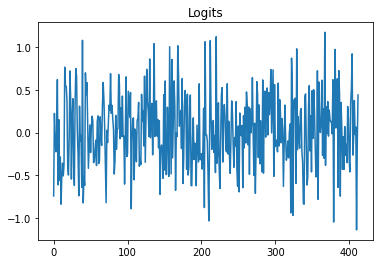

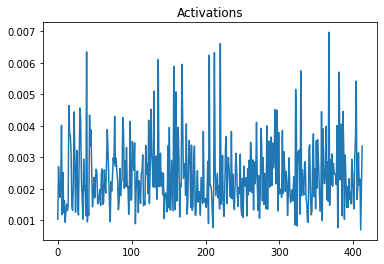

In [18]:
import random
import matplotlib.pyplot as plt
import torch

inputs = [random.choice(dataset_train_tokenized)]
inputs = data_collator(inputs)
assert list(inputs.keys()) == ["input_ids", "attention_mask", "labels"], list(inputs.keys())
print("input_ids:", inputs["input_ids"])
print("")

outputs = model(**inputs)
assert list(outputs.keys()) == ["loss", "logits", "past_key_values"], list(outputs.keys())
print("logits:", outputs["logits"])

plt.plot(outputs["logits"].detach().numpy()[0][0])
plt.title("Logits")
plt.show()
plt.close()

activations = torch.nn.functional.softmax(outputs["logits"], dim=-1)
plt.plot(activations.detach().numpy()[0][0])
plt.title("Activations")
plt.show()
plt.close()

# Train the-jam-machine

## Initialize Weight and Biases

In [19]:
# Weight and Biases
import wandb
os.environ["WANDB_NOTEBOOK_NAME"] = "the-jam-machine_2022_12_04"
wandb.init(project="the-jam-machine-test")

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find the-jam-machine_2022_12_04.
wandb: Currently logged in as: misnaej. Use `wandb login --relogin` to force relogin


## Train from scratch or Train from a checkpoint ?

In [20]:
if train_from_scratch:
  train_from_this_checkpoint = None
  train_from_this_checkpoint_model_path = model_path

elif not train_from_scratch:
  train_from_this_checkpoint_model_path = "/content/drive/MyDrive/the_jam_machine/model_2048_fulldataset"
  train_from_this_checkpoint = "checkpoint-3900"
  additionnal_epochs_to_run = 0

## Training

Check those links (Hugging Face): 
- [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer)
- [trainer_utils.py](https://github.dev/huggingface/transformers/blob/main/src/transformers/trainer_utils.py)

- [TrainingArguments (training_args.py)](https://github.com/huggingface/transformers/blob/main/src/transformers/training_args.py)

In [ ]:
from transformers import TrainingArguments, Trainer
import os
# Create the trainer.
print("Creating trainer...")
eval_steps = 1_000
per_device_train_batch_size = 8
num_train_epochs = 2
output_path = train_from_this_checkpoint_model_path

training_args = TrainingArguments(
    output_dir=output_path, # where model and checkpoints will be saved
    overwrite_output_dir=True,# self-explanatory
    num_train_epochs=num_train_epochs, # defaults to 3.0
    evaluation_strategy="steps", # Evaluation is done (and logged) every eval_steps (so not at the end of every epoch)
    eval_steps=eval_steps, # Number of update steps (backprob) between two evaluations
    learning_rate=5e-4, #initial learning rate for :class:`~transformers.AdamW` optimizer.
    weight_decay=0.15, # Default o.
    warmup_steps=20_000,
    lr_scheduler_type="cosine", # Default linear
    fp16=False, # Default False. Is True in HF.
    bf16_full_eval=False,
    per_device_train_batch_size=per_device_train_batch_size, #default value is 8
    seed=42, # default seed=42
    save_strategy="steps", # 
    save_steps=10_000,
    save_total_limit=5,
    logging_strategy="steps",
    logging_first_step=True,
    logging_steps=eval_steps,
    logging_dir=os.path.join(output_path, "logs"),
    prediction_loss_only=False,
    report_to="wandb",
    load_best_model_at_end=True,
    metric_for_best_model="loss", # "eval_loss"
    hub_strategy="checkpoint", #huggingface repo -> saves the last checkpoint to huggingface
    hub_model_id=hf_repo,
    hub_token=hf_token,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset_train_tokenized,
    eval_dataset=dataset_val_tokenized,
)

# Train the model.
if train_from_scratch:
  trainer.train()
else:
  if train_from_this_checkpoint is not None:
    trainer.args.num_train_epochs += additionnal_epochs_to_run
    trainer.train("/content/drive/MyDrive/the_jam_machine/model_2048_fulldataset/checkpoint-39000")

  else:
    pass

# Save the tokenizer.
tokenizer.save_pretrained(output_path)
# Save the model.
model.save_pretrained(output_path)



Creating trainer...


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 365999
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 91500
  Number of trainable parameters = 25955840
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss


In [ ]:
# Save the tokenizer.
tokenizer.save_pretrained(output_path)
# Save the model.
model.save_pretrained(output_path)

# Generate from the-jam-machine

In [ ]:
# load and generate


# Load the model.

# generating the 9th bar: getting rid of the first bar and generating one more... then 

# conditioning: density token ; why do you use the density bins: because it carries the musical style
# prompt 

# PIECE_START TRACK INST=34 DENSITY=6 ........ TRACK_END
# DENSITY: FOR EACH INSTRUMENTB THEY COUNT THE NOTE IN THE 8 BARS: THEY DO THE PERCENTILE


## TO DO



# Utilities

In [ ]:
# !pip install numba
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()